In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
import time
from scipy.stats import shapiro, mannwhitneyu, norm
import numpy as np
from tqdm.auto import tqdm

## Task 1: RR calculation

In [14]:
# field for inputs

reg_data_link = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-mitjaeva-22/shared/problem1-reg_data.csv'
auth_data_link = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-mitjaeva-22/shared/problem1-auth_data.csv'

start_dt = "2020-09-08"
end_dt   = "2020-09-22"
period   = 12

In [15]:
def retention (reg_data_link, auth_data_link, start_dt = '1970-01-01', end_dt = time.strftime("%Y-%m-%d"), period = 'without_restriction'):

# read data
    reg_data  = pd.read_csv(reg_data_link, sep=';') 
    auth_data = pd.read_csv(auth_data_link, sep=';')
    
    
# transform
    reg_data["cohort"]   = pd.to_datetime(reg_data['reg_ts'].swifter.apply(pd.to_datetime,   unit='s').dt.date)
    auth_data["auth_dt"] = pd.to_datetime(auth_data['auth_ts'].swifter.apply(pd.to_datetime, unit='s').dt.date)
    
# set time filter
    reg_data  = reg_data.query('cohort >= @start_dt and cohort <= @end_dt')
    auth_data = auth_data.query('auth_dt >= @start_dt')
    
#   join registration and session data
    df = reg_data.merge(auth_data, on='uid', how='left')

    df = df.groupby(['cohort', 'auth_dt'], as_index=False) \
                  .agg(user_count=('uid', 'nunique'))
    
# calculate time delta
    df['period_number'] = (df.auth_dt - df.cohort).dt.days
    
# optional parameter. If the period is not set, then the indicator will be calculated for all available time
    if period != 'without_restriction':
        df = df.query('period_number <= @period')
        
# convert dates to string format        
    df["cohort"] = df["cohort"].astype(str)
    
    cohort_pivot = df.pivot_table(index = 'cohort',
                                columns = 'period_number',
                                 values = 'user_count')

    cohort_size      = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# consider max to adapt the coloring
    max = retention_matrix.loc[:,1:].max().max()
    
# stylize
    sns.set(style='ticks')
    plt.figure(figsize=(15, 10))
    plt.title('Cohorts: User Retention')
    sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, fmt='.1%', vmax = max, cmap='BuPu')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


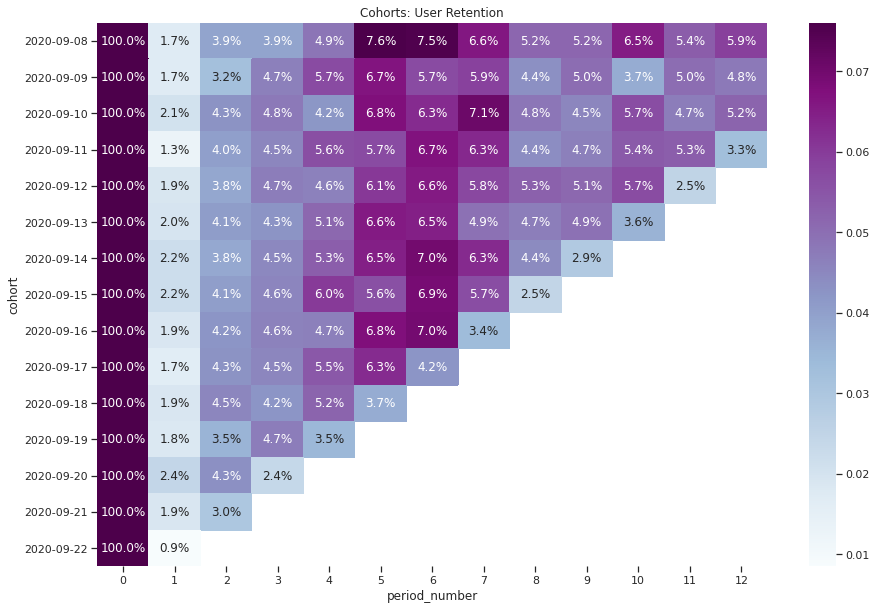

In [16]:
retention(reg_data_link, auth_data_link, start_dt, end_dt, period)

## Task 2: A/B test

*A/B test results are available, in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. At the same time, in the control group, 1928 players out of 202103 turned out to be paying, and in the test group - 1805 out of 202667.*

*Which set of proposals can be considered the best? What metrics should be analyzed to make the right decision and how?*

In [17]:
url = 'https://raw.githubusercontent.com/marinamityaeva/karpov-courses-project/main/ab_test.csv'

df_2 = pd.read_csv(url, sep = ';')

Conducting a short EDA (Exploratory data analysis)

In [18]:
df_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [19]:
df_2.shape

(404770, 3)

In [21]:
# aggregate data by users
df_2.user_id.nunique()

404770

Let's look at the descriptive revenue statistics. We see that the average value of revenue is 26, while the 75th percentile is 0, and the maximum value is 37433.
This means two things:

a) The indicator is clearly not normally distributed

b) Most users don't make money

In [22]:
df_2.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

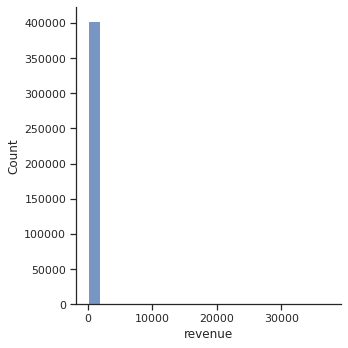

In [23]:
# Verifying this on the graph of the distribution of users by revenue
sns.displot(df_2.revenue)

At the second stage, we will determine the key metrics on the basis of which we will make a decision on the effectiveness of promotional offers.

For the right choice of metrics, of course, it is important to take into account the specifics and economics of the business. We do not have enough input data for this, however, if we assume that in an online game, expenses make up a small share of revenue and most of it is converted into profit, then ARPU and ARPPU are good metrics for making a decision. At the same time, most likely, the company's expenses are evenly divided among all players and do not depend on the participation of players in auction offers, so ARPU will be a more main metric, and ARPPU - a secondary one. We will make a decision, first of all, based on changes in ARPU, because ARPPU may increase as a result of the change in promotional offers, but users may begin to participate less in promotions and the average revenue and profit of the company will thus decrease.

Thus, the testing hypothesis will sound like this:
H0: There is no effect from changing promotional offers, that is, ARPU in the test and control groups do not have statistically significant differences
H1: There is an effect of the changes, ARPU differs statistically significantly in the test and control groups

You can check these hypotheses, for example, using t-test, in the case of a normal distribution of the indicator.
If the indicator is not distributed according to the normal distribution law, then hypotheses can be tested using a non-parametric analogue of the t-test - the Mann-Whitney U-test, which is less sensitive to extreme deviations from normality and the presence of outliers, as well as using Bootstrap analysis.

We will test hypotheses at the 0.05 significance level

In [24]:
#   divide data into test and control groups
control = df_2.query('testgroup == "a"')
test    = df_2.query('testgroup == "b"')

#   test and control group of paying users
control_p = control.query('revenue > 0')
test_p    =    test.query('revenue > 0')

In [25]:
#   we consider the change in ARPU in groups. ARPU in the test group increased by 5.3%
ARPU_test    = test.revenue.sum()    / test.user_id.count()
ARPU_control = control.revenue.sum() / control.user_id.count()

round((ARPU_test - ARPU_control) / ARPU_control * 100, 1)

5.3

In [27]:
#  we consider the change in ARPPU in groups. ARPPU in the test group increased by 12.7%
ARPU_test_p    = test_p.revenue.sum()    / test_p.user_id.count()
ARPU_control_p = control_p.revenue.sum() / control_p.user_id.count()

round((ARPU_test_p - ARPU_control_p) / ARPU_control_p * 100, 1)

12.7

In [28]:
#   count conversions into purchases. Conversion to purchase in the test group decreased by 6.6%
CR_test    = test_p.user_id.count()    / test.user_id.count()
CR_control = control_p.user_id.count() / control.user_id.count()

round((CR_test - CR_control) / CR_control * 100, 1)

-6.6

In order to analyze the statistical significance of the obtained differences, it is necessary to determine whether the value is distributed according to
normal law to understand which statistical test is best to use. Let's preliminarily analyze
distributions through visualization.

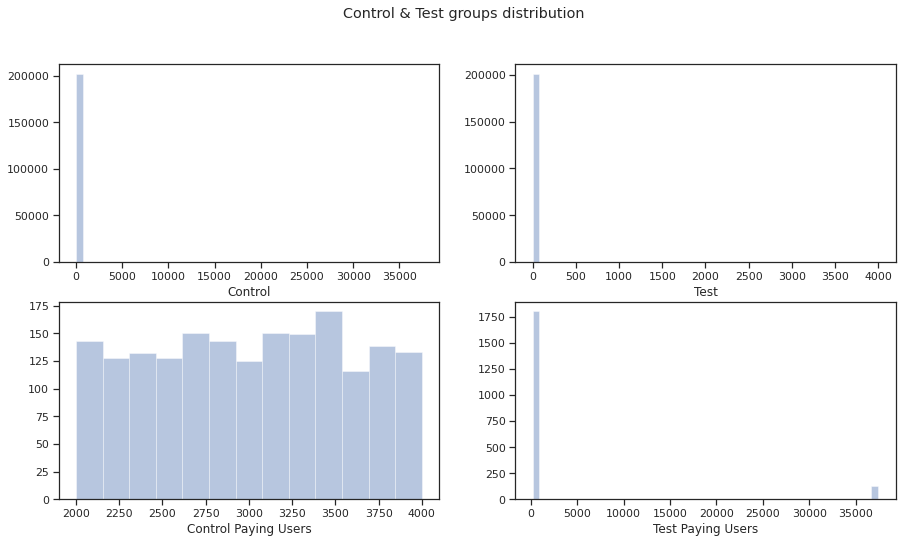

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle("Control & Test groups distribution")

sns.distplot(ax=axes[0, 0], x = control.revenue,   axlabel = 'Control',              kde = False)
sns.distplot(ax=axes[0, 1], x = test.revenue,      axlabel = 'Test',                 kde = False)
sns.distplot(ax=axes[1, 0], x = test_p.revenue,    axlabel = 'Control Paying Users', kde = False)
sns.distplot(ax=axes[1, 1], x = control_p.revenue, axlabel = 'Test Paying Users',    kde = False)

The distributions seem to be different from normal. We will verify this using the Shapiro-Wilk criterion

The null hypothesis of the Shapiro-Wilk Ho test is that the random variable is distributed according to the normal law
The alternative hypothesis H1 is that the distribution law is not normal

The criterion can work incorrectly on large samples, detecting even the smallest deviations from normality.
To avoid this shortcoming, we will use it on random 1000 values from the samples

In [30]:
# make selections of 1000 users from each of the groups
sample_control = control.sample(1000)
sample_test = test.sample(1000)

# run the Shapiro-Wilk test on samples
print('control:', shapiro(sample_control.revenue))
print('test:' , shapiro(sample_test.revenue))

control: ShapiroResult(statistic=0.07228094339370728, pvalue=0.0)
test: ShapiroResult(statistic=0.07242286205291748, pvalue=0.0)


p-value in both groups is zero, hence H0 is rejected even at a very high level of significance, and this confirms the fact that the indicator does not have a normal distribution.

Because the indicator is not distributed according to the normal law, we will use the Mann-Whitney test to test the hypotheses.

In [31]:
# applying the Mann-Whitney test
mannwhitneyu(control.revenue, test.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

Since p-value > α = 0.05, we do not reject H0 in favor of H1. However, the p-value is still quite small, so it does not hurt to check the conclusions using another method - bootstrap analysis, based on multiple generation of samples based on the existing sample.

In [32]:
# create a function for conducting Bootstra-analysis
def get_bootstrap(
        data_column_1,
        data_column_2,
        boot_it = 1000,
        statistic = np.mean,
        bootstrap_conf_level = 0.95):
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('booted_data')
    plt.ylabel('frequency')
    plt.title("Histogram of booted_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants"   : quants, 
            "p_value"  : p_value}

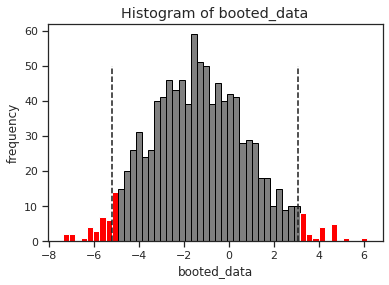

In [33]:
booted_data = get_bootstrap(control.revenue, test.revenue)

In [34]:
booted_data["p_value"]

0.539439624777573

p-value is greater than the threshold value of 0.05, the hypothesis of statistical significance of the differences is rejected

In [35]:
booted_data["quants"]

,0
0.025,-5.195866
0.975,3.073431


Output:
Although ARPU and ARPPU in the test group were higher than in the control group, this does not allow us to conclude that the new promotional offers are effective. Two statistical methods (Mann-Whitney test and Bootstrap analysis) did not show statistically significant changes in the main and most important metric for this company - ARPU, which means that the differences in the indicator in the test and control groups are random.

In this case, we cannot conclude that the test version of the promotional offers has won and we recommend returning to the control version of the promotional offers.

## Задание 3

*Plants & Gardens has limited-time themed events every month. In them, players can get unique items for the garden and characters, additional coins or bonuses. To receive a reward, you need to complete a series of levels in a certain time. Which metrics can be used to evaluate the results of the last past event?*

We look at all the metrics in dynamics: before the promotion, during and after, comparing the level of interest in the game before the promotion and after. To evaluate the holding of a thematic event, I propose to analyze the following metrics:

a) monetary: show the dynamics of interest and engagement from users in money

1) ARPU: average check among all users \
2) ARPPU: average check among all users among active/paying users \
3) Conversion to purchase

b) non-monetary: show audience dynamics and engagement

1) Renetion/Churn rate: a sharp inflow/outflow of users signals a positive/negative user experience and high/low interest in the event as a whole \
2) DAU: Active audience engagement is also a positive indicator that can have an impact on monetary metrics \
3) ASL / Average session length: characterizes user engagement \
4) Number of sessions: an increase in the number of opening the application may indicate that the user is getting used to the application and the level of interest is normalizing, which favorably affects the retention / churn rate \
5) Interval between sessions: the less the better \
6) k factor: the more often users invite other users, the higher the virality of the application, which favorably affects organic growth, compensating for paid ways of attracting


It is also necessary to analyze the conversion in terms of the funnel of levels to manage the outflow of users

*Let's say in another event we complicated the mechanics of events so that each time the player fails to complete a level, the player will roll back several levels. Will the set of performance evaluation metrics change? If yes, how?*

To evaluate complicated mechanics with a potential rollback of levels on an unsuccessful attempt, I would suggest evaluating the following indicators

a) gaming \
1) Average and median number of attempts by users who passed all levels \
2) Average time to complete all levels \
3) Average number of rollbacks among users 

b) business \
1) Number of app crashes \
2) Number of renewed subscriptions \
3) Average time to first purchase (reducing the metric compared to the old mechanics will help draw conclusions about how much the new format encourages the user to purchase additional services) \
4) reviews / ratings (direct impact game experience)

Similar to the remark above, it is necessary to adjust the funnel for the new mechanism and analyze the conversion by levels